# 영국의 호흡기 질환 사망자 수

In [51]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# MacOS 한글 설정
from matplotlib import rc
rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False   # minus 표시

In [20]:
# time: 1년을 1.0으로, 1개월을 1/12로 하는 값(year-fraciton)으로 인코딩
df = sm.datasets.get_rdataset("deaths", "MASS").data
df.head()

,time,value
0,1974.000000,3035
1,1974.083333,2552
2,1974.166667,2704
3,1974.250000,2554
4,1974.333333,2014


In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False    # minus 표시
mpl.rc('font', family='NanumGothic')
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["font.size"] = 14

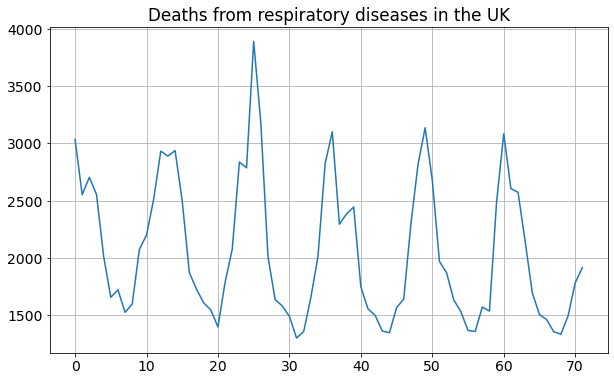

In [22]:
df.value.plot()
plt.title("Deaths from respiratory diseases in the UK")
plt.grid()
plt.show()

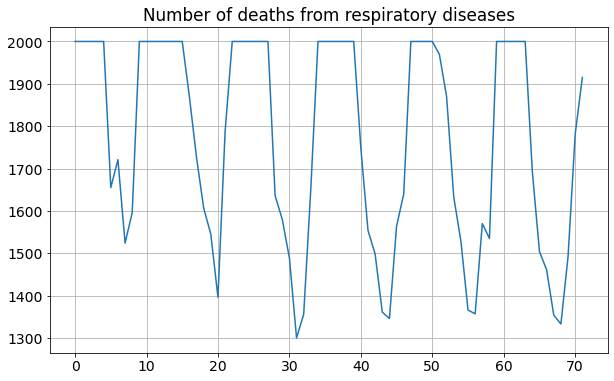

In [28]:
df["cliped_value"] = df.value.clip(upper=2000)
df.cliped_value.plot()
plt.title("Number of deaths from respiratory diseases")
plt.grid() 
plt.show() 

### 자기회귀이동평균 (ARMA: Autoregressive Moving Average) 모형 생성
- 자기회귀와 이동평균으로 확률적 시계열을 표현
- ARMA(p, q)
- p: 자기회귀 다항식의 차수(order), 여기선 1
- q: 이동평균 다항식의 차수(order), 여기선 2

In [29]:
sm.tsa.ARMA

statsmodels.tsa.arima_model.ARMA

In [30]:
model_ARMA = sm.tsa.ARMA(df["cliped_value"], (1,2))
result_ARMA = model_ARMA.fit()
print(result_ARMA.summary())

                              ARMA Model Results                              
Dep. Variable:           cliped_value   No. Observations:                   72
Model:                     ARMA(1, 2)   Log Likelihood                -460.457
Method:                       css-mle   S.D. of innovations            143.769
Date:                Thu, 09 Jul 2020   AIC                            930.915
Time:                        05:21:39   BIC                            942.298
Sample:                             0   HQIC                           935.447
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1782.0426     64.334     27.700      0.000    1655.950    1908.136
ar.L1.cliped_value     0.5829      0.130      4.496      0.000       0.329       0.837
ma.L1.cliped_value  

### ARMA 모형으로 예측한 시계열과 실제 시계열을 비교

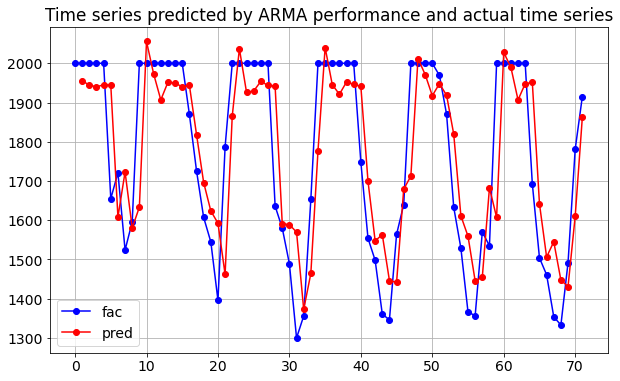

In [32]:
plt.plot(df["cliped_value"], "bo-", label="fac")
plt.plot(result_ARMA.predict(1), "ro-", label="pred")
plt.title('Time series predicted by ARMA performance and actual time series')
plt.legend()
plt.grid()
plt.show() 

### 자기회귀이동평균 (ARMA: Autoregressive Moving Average) 모형 생성
- 자기회귀와 이동평균으로 확률적 시계열을 표현
- ARMA(p, q)
- p: 자기회귀 다항식의 차수(order), 여기선 1
- q: 이동평균 다항식의 차수(order), 여기선 2

In [33]:
model_ARMA = sm.tsa.ARMA(df["cliped_value"], (1,2))
result_ARMA = model_ARMA.fit()
print(result_ARMA.summary())

                              ARMA Model Results                              
Dep. Variable:           cliped_value   No. Observations:                   72
Model:                     ARMA(1, 2)   Log Likelihood                -460.457
Method:                       css-mle   S.D. of innovations            143.769
Date:                Thu, 09 Jul 2020   AIC                            930.915
Time:                        05:25:09   BIC                            942.298
Sample:                             0   HQIC                           935.447
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1782.0426     64.334     27.700      0.000    1655.950    1908.136
ar.L1.cliped_value     0.5829      0.130      4.496      0.000       0.329       0.837
ma.L1.cliped_value  

### ARMA 모형으로 예측한 시계열과 실제 시계열을 비교

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


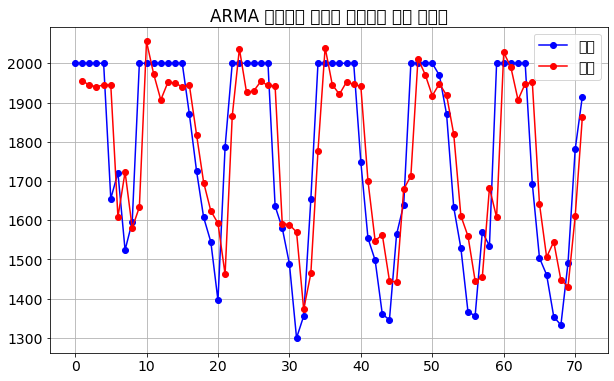

In [52]:
plt.plot(df["cliped_value"], "bo-", label="실제")
plt.plot(result_ARMA.predict(1), "ro-", label="추정")
plt.title('ARMA 모형으로 예측한 시계열과 실제 시계열')
plt.legend()
plt.grid()
plt.show() 

### RNN 모형으로 예측
- 타입스텝: 7
- 평균과 분산으로 정규화한 값을 데이터로 사용

In [36]:
ts = 7

df["cliped_std_value"] = \
    df.cliped_value.map(lambda x : (x - df.cliped_value.mean()) / np.std(df.cliped_value))
X_train = np.asarray([np.array([df.cliped_std_value.values[i+j] for j in range(ts)])
                      for i in range(len(df.cliped_std_value) - ts)]).reshape(-1,ts,1)
y_train = df.cliped_std_value.values[ts:]
X_train.shape, y_train.shape

((65, 7, 1), (65,))

In [37]:
df.head() 

,time,value,cliped_value,cliped_std_value
0,1974.000000,3035,2000,0.93284
1,1974.083333,2552,2000,0.93284
2,1974.166667,2704,2000,0.93284
3,1974.250000,2554,2000,0.93284
4,1974.333333,2014,2000,0.93284


In [38]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

In [39]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(100, input_shape=(ts, 1)))
model_RNN.add(Dense(1, activation="linear"))
model_RNN.compile(loss='mse', optimizer='adam')
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/

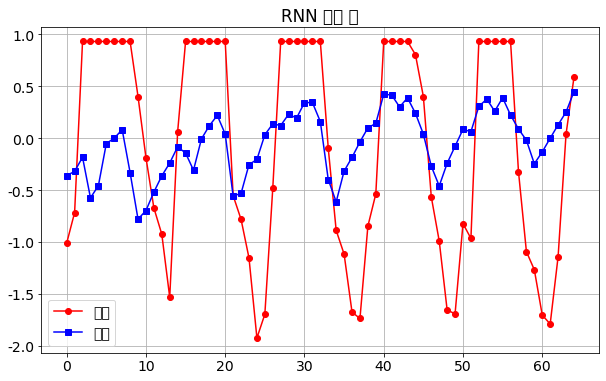

In [40]:
plt.plot(y_train[:], 'ro-', label="실제")
plt.plot(model_RNN.predict(X_train[:, :, :]), 'bs-', label="추정")
plt.legend()
plt.title("RNN 학습 전")
plt.grid()
plt.show()

In [41]:
history_RNN = model_RNN.fit(X_train, y_train, epochs=1000, verbose=0)
history_RNN.history['loss'][-1] 

0.05399695038795471

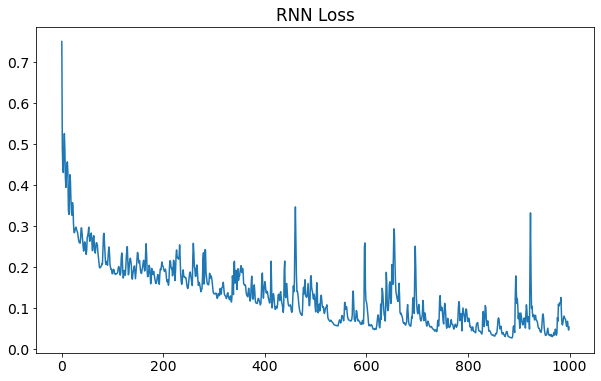

In [42]:
plt.plot(history_RNN.history["loss"])
plt.title("RNN Loss")
plt.show() 

/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/

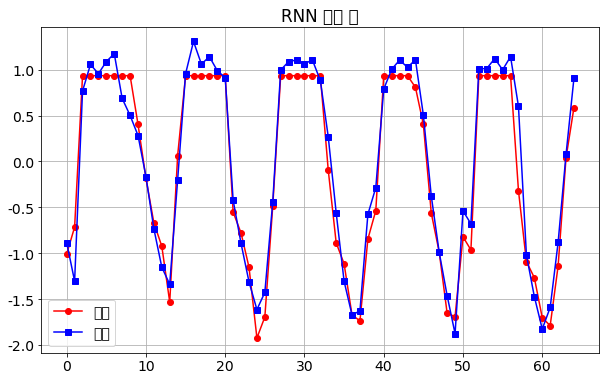

In [43]:
plt.plot(y_train[:], 'ro-', label="실제")
plt.plot(model_RNN.predict(X_train[:, :, :]), 'bs-', label="추정")
plt.legend()
plt.title("RNN 학습 후")
plt.grid()
plt.show() 

### LSTM 모형

In [44]:
from keras.layers import LSTM

model_LSTM = Sequential()
model_LSTM.add(LSTM(100, input_shape=(ts, 1)))
model_LSTM.add(Dense(1, activation="linear"))
model_LSTM.compile(loss='mse', optimizer='adam')
model_LSTM.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site

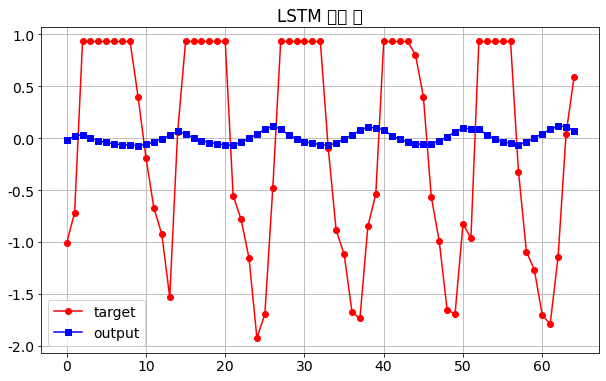

In [45]:
plt.plot(y_train[:], 'ro-', label="target")
plt.plot(model_LSTM.predict(X_train[:, :, :]), 'bs-', label="output")
plt.legend()
plt.title("LSTM 학습 전")
plt.grid()
plt.show() 

In [46]:
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=1000, verbose=0)
history_LSTM.history['loss'][-1] 

0.12527123093605042

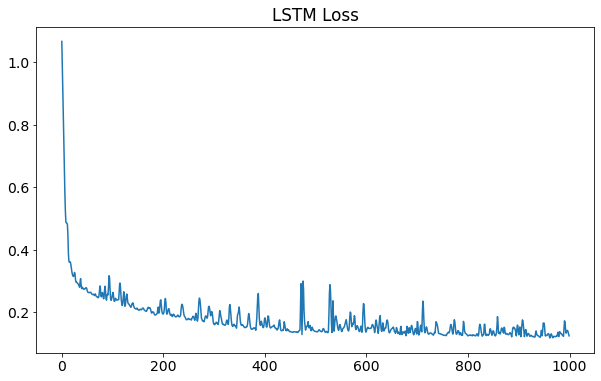

In [47]:
plt.plot(history_LSTM.history["loss"])
plt.title("LSTM Loss")
plt.show()

/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ryung/anaconda3/envs/tf2/lib/python3.8/site

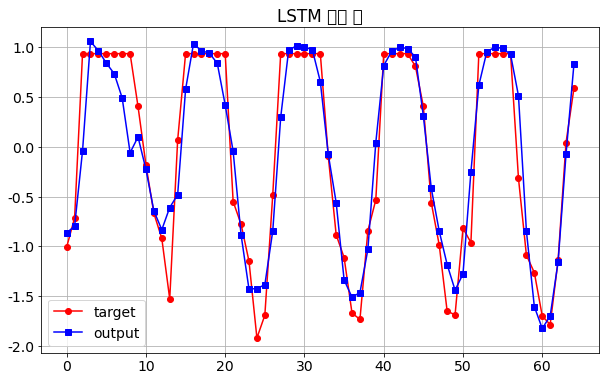

In [48]:
plt.plot(y_train[:], 'ro-', label="target")
plt.plot(model_LSTM.predict(X_train[:, :, :]), 'bs-', label="output")
plt.legend()
plt.title("LSTM 학습 후")
plt.grid()
plt.show() 